Implementing a basic DE solver for the neutrino winds in terms of psi

Runge-Kutta method from Wikipedia:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/25f03454fd25957cc63be11ec534efdce349c52f">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/95bdbb2e3aa83735085c0aadd577162c69e4056a">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/81398071e8f180ac143bfdf4598ff47bf79eb689">
I use $\psi$ in place of t, and {r,v} as y. I calculate separate k values for r and v to get y'={r',v'}

Questions/next steps:

Isentropic wind with ideal gas equation of state<br />
check small v0 - no turnover I can find<br />
check limits of gamma, maybe find v0 as a function of gamma<br />
calculate realistic a value<br />
incorporate general EoS, not just gamma law

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
np.seterr(all='raise')

#AV=False
cs=1
M=10
G=1
mB=1
dPdS=1
Se=0
rho=1
T=1
r0=1
gamma=1.
T0=mB*(cs**2)/gamma

W0=np.log(1)

a=G*M/((cs**2)*r0)

def ndf1(psi,coords):
    '''Dimensionless f1 function, takes t,(x,y) and returns 1-exp[2y]'''
    try:
        #return 1-np.exp(2*coords[1])
        return 1-np.exp(2*coords[1]-coords[2])
    except OverflowError or UnderflowError:
        print("Error in ndf1 at ",psi,", ",coords)
        return -1

def ndf2(psi,coords):
    '''Dimensionless f2 function, takes t,(x,y) and returns (GM/r0*cs^2)exp[-x]-2'''
    try:
        #return np.exp(-coords[0])*a-2
        return a*np.exp(-coords[0]-coords[2])-2
    except OverflowError or UnderflowError:
        print("Error in ndf2 at ",psi,", ",coords)
        return -1

def dx(t,state):
    return ndf1(t,state)
    #return state[0]
def du(t,state):
    return ndf2(t,state)
    #return state[1]
def dw(t,state):
    return -(gamma-1)*(2*ndf1(t,state)+ndf2(t,state))
    #return state[2]

def adx(t,state):
    return abs(ndf1(t,state))
def adu(t,state):
    return abs(ndf2(t,state))
def adw(t,state):
    return -(gamma-1)*(2*abs(ndf1(t,state))+abs(ndf2(t,state)))

def CoupledRKStep(funs,state,dt):
    """RK step for array of coupled functions that evolve a state, for step size dt
    Returns array (t,new state)
    funs and state[1] should have the same length
    
    Parameters:
        funs: array of functions
        state: numpy array [t,[x,u,w]]
        dt: generalized time step size
        
    Returns:
        numpy array [t,[x,u,w]] incremented by one RK4 step
    """
    assert type(funs)==list, "Expected array input"
    for i in funs:
        assert callable(i), "Expected functions in list"
    assert type(state)==np.ndarray or type(state)==list, "Expected array input"
    assert np.shape(state)==(2,), "Expected 1D array with 2 elements"
    assert type(state[1])==np.ndarray or type(state)==list, "Expected array in second element"
    assert np.shape(state[1])==(len(funs),), "State and function arrays are different lengths"
    assert type(dt)==float or type(dt)==np.float64, "Expected float input"
    
    
    karr=np.array([np.zeros(4) for i in range(len(funs))])
    for j in range(4):
        for i in range(len(funs)):
            if j==0:
                karr[i][j]=dt*funs[i](state[0],state[1])
            else:
                karr[i][j]=dt*funs[i](state[0]+dt/2,state[1]+np.array([karr[k][j-1]/2 for k in range(len(karr))]))
    for i in range(len(funs)):
        karr[i][1]=2*karr[i][1]
        karr[i][2]=2*karr[i][2]
    step=np.array([state[1][i]+np.sum(karr[i])/6 for i in range(len(karr))])
    return np.array([state[0]+dt,step])
        

def percentChange(curr,step):
    """Takes a current state and a new state (vectors) and calculates the percent change
    
    Parameters:
        curr: numpy array (x,u)
        step: numpy array (x',u')
    
    Returns:
        Percent change from curr to step"""
    
    assert type(curr)==np.ndarray or type(curr)==list, "Expected array input"
    assert type(step)==np.ndarray or type(step)==list, "Expected array input"
    assert len(curr)==len(step), "Array lengths are not the same"
    
    return 100*abs(np.linalg.norm((step-curr)/np.linalg.norm(curr)))

def adaptRK(currState,pc,t,dt,funs):
    """Adapts dt to ensure the change in (x,u) is between .1 and 1 percent
    This system does not always behave as expected, so the adaptation iteratively finds a new dt to correct the error
    This new dt can be either larger or smaller, independent of the initial percent change
    Takes a state (x,u), a percent change, t, dt, and absolute value (boolean)
    
    Parameters:
        currState: numpy array (x,u)
        pc: percent change between currState and the next RK step with t, dt
        t: generalized time of currState
        dt: generalized time step size
        AV: use the absolute value of f1 and f2 (boolean)
        
    Returns:
        dt, adjusted so that the percent change is between .1 and 1 percent"""
    
    assert type(funs)==list, "Expected array input"
    for i in funs:
        assert callable(i), "Expected functions in list"
    assert type(currState)==np.ndarray or type(state)==list, "Expected array input"
    assert np.shape(currState)==(len(funs),), "Expected 1D array input"
    assert type(dt)==float or type(dt)==np.float64, "Expected float input"
    assert type(t)==int or type(t)==float or type(t)==np.float64, "Expected float input, got {0}".format(type(t))
    assert type(pc)==float or type(pc)==np.float64, "Expected float input"
    
    ddt=1.5
    i=0
    itermax=10000
    if pc>1:
        pc2=1e10 #initialize dummy percent changes, used to track movement in % change while finding new dt
        prevpc2=1e10
        while pc2>1 and i<itermax:
            dt=dt*ddt
            step2=CoupledRKStep(funs,[t,currState],dt) #calculate hypothetical next step using new dt
            pc2=percentChange(currState,step2[1])
            if pc2>prevpc2: #if we're moving in the wrong direction, invert our change in dt
                ddt=1/ddt
            prevpc2=pc2
            i=i+1
        if i==itermax: print("Max iteration count exceeded in adaptation")
        return dt #once we've found a working dt, take a step using it
    elif pc<.1: 
        pc2=1e-10 #initialize dummy percent changes, used to track movement in % change while finding new dt
        prevpc2=1e-10
        while pc2<.1 and i<itermax:
            dt=dt*ddt
            step2=CoupledRKStep(funs,[t,currState],dt) #calculate hypothetical next step using new dt
            pc2=percentChange(currState,step2[1])
            if pc2<prevpc2: #if we're moving in the wrong direction, invert our change in dt
                ddt=1/ddt
            prevpc2=pc2
            i=i+1
        if i==itermax: print("Max iteration count exceeded in adaptation")
        return dt #once we've found a working dt, take a step using it

def generateFunc(state0,itermax=10000,AV=True,xrange=10,urange=5):
    """Generates a trace of wind behavior with initial conditions x0 and u0 (dimensionless) using the RK4 method with adaptation in dt
    Takes x0, u0, max iteration count and returns a 2D array tracking t, x, and u
    
    Parameters:
        x0: starting x value
        u0: starting u value
        itermax: maximum iteration count for loop
        AV: use the absolute value of f1 and f2 (boolean)
        xrange: maximum x value to display on plot (displays (1,xrange))
        urange: maximum u value to display on plot (displays (0,urange))
    
    Returns:
        numpy array, [0] contains t values, [1] contains x values, [2] contains u values for the wind curve"""
    
    assert type(state0)==list or type(state0)==np.ndarray, "Expected array input"
    assert len(state0)==3, "Expected state array of length 3"
    assert type(itermax)==int, "Expected integer input"
    assert itermax>0, "Expected positive itermax"
    assert type(AV)==bool, "Expected boolean input"
    assert type(xrange)==int or type(xrange)==float, "Expected numerical input"
    assert xrange>1, "Expected xrange>1"
    assert type(urange)==int or type(urange)==float, "Expected numerical input"
    assert urange>0, "Expected positive urange"
    
    xsol=np.array([state0[0]])
    usol=np.array([state0[1]])
    wsol=np.array([state0[2]])
    tarray=np.array([0])
    t=0
    dt=.01
    i=0
    currState=np.array([xsol[-1],usol[-1],wsol[-1]])
    
    if AV:
        funs=[adx,adu,adw]
    else:
        funs=[dx,du,dw]
    
    #Main loop for adaptive RK solver
    #Exit conditions are based on values for exp(x)
    #Using zero points for f1 and f2 only works if you change ndf1 and ndf2 to return absolute values, and then you don't see the full curve
    #Setting a max iteration count doesn't always work well - the solution curves may be cut
    while np.exp(currState[0])>1e-6 and np.exp(currState[0])<xrange and i<itermax: #and abs(ndf1(t,currState))>.001 and ndf2(t,currState)>.001:
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([xsol[-1],usol[-1],wsol[-1]])
        
        #Calculate the next integration step using the RK function defined above
        step=CoupledRKStep(funs,[t,currState],dt)
        
        #Calculate percent change from current state to predicted next state
        try:
            pc=percentChange(currState,step[1])
        except:
            print("Error at %change, currState: ",currState," step: ",step)
            break
        
        #If the percent change is too large or too small, change dt to compensate
        if pc>1 or pc<.1:
            dt=adaptRK(currState,pc,t,dt,funs)
            step=CoupledRKStep(funs,[t,currState],dt)
        
        xsol=np.append(xsol,step[1][0]) #update solution curves with next step
        usol=np.append(usol,step[1][1])
        wsol=np.append(wsol,step[1][2])
        t=t+dt
        i=i+1
        tarray=np.append(tarray,t)
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return np.array((tarray,xsol,usol,wsol))

def makePlot(u0,AV=True,xrange=10,urange=5):
    """Generates a plot of one wind curve
    Takes u0 and generates a curve
    Returns 0, prints a plot of the wind curve
    
    Parameters:
        u0: initial value of u
        AV: use absolute value of f1 and f2 functions (boolean)
        xrange: maximum x value to display on plot (displays (1,xrange))
        urange: maximum u value to display on plot (displays (0,urange))
        
    Returns:
        0
    
    Displays a plot of one wind curve"""
    
    assert type(u0)==float, "Expected float input"
    assert u0>0, "Expected positive input"
    assert type(AV)==bool, "Expected boolean input"
    assert type(xrange)==int or type(xrange)==float, "Expected numerical input"
    assert xrange>1, "Expected xrange>1"
    assert type(urange)==int or type(urange)==float, "Expected numerical input"
    assert urange>0, "Expected positive urange"
    
    plt.figure(1)
    plt.xlim(1,xrange)
    plt.ylim(0,urange)

    func=generateFunc(np.array([0,np.log(u0),W0]),10000,AV,xrange,urange)
    plt.scatter(np.exp(func[1]),np.exp(func[2]),s=.5);
    return 0

def makePlots(vmin,vmax,dv,AV=True,xrange=10,urange=5):
    """Generates a plot of wind curves
    Takes vmin, vmax, dv and generates a curve for u0 (x0=0), then increments v0 by dv and generates a new curve, repeating until v0=umax
    Expects vmin, vmax, and dv scaled by 1/cs
    Returns 0, prints a plot of the different wind curves
    
    Parameters:
        umin: starting u value
        umax: maximum u value
        du: increment of u
        AV: Use absolute value of f1 and f2 functions (boolean)
        xrange: maximum x value to display on plot (displays (1,xrange))
        urange: maximum u value to display on plot (displays (0,urange))
    
    Returns:
        0
    
    Displays a plot of several different wind curves"""
    
    assert type(vmin)==float, "Expected float input"
    assert vmin>0, "Expected positive input"
    assert type(vmax)==float, "Expected float input"
    assert vmax>0, "Expected positive input"
    assert type(dv)==float, "Expected float input"
    assert dv>0, "Expected positive input"
    assert vmax>vmin, "Maximum less than minimum"
    assert type(AV)==bool, "Expected boolean input"
    assert type(xrange)==int or type(xrange)==float, "Expected numerical input"
    assert xrange>1, "Expected xrange>1"
    assert type(urange)==int or type(urange)==float, "Expected numerical input"
    assert urange>0, "Expected positive urange"
    
    plt.figure(1)
    plt.xlim(1,xrange)
    plt.ylim(0,urange)

    
    for i in np.arange(vmin,vmax,dv):
        #print("\n*******iteration********* ",i,"\n")
        func=generateFunc(np.array([0,np.log(i),W0]),10000,AV,xrange,urange)
        if i==vmin:
            data=[func]
        else:
            #print(i)
            #print(data)
            data.append(func)
        plt.scatter(np.exp(func[1]),np.exp(func[2]),s=.5);

    print("v vs r:")
    plt.figure(1)
    for i in range(len(data)):
        plt.scatter(np.exp(data[i][1]),np.exp(data[i][2]),s=.5);
    print("T vs r:")
    plt.figure(2)
    for i in range(len(data)):
        plt.scatter(np.exp(data[i][1]),np.exp(data[i][3]),s=.5);
    print("T vs v:")
    plt.figure(3)
    for i in range(len(data)):
        plt.scatter(np.exp(data[i][2]),np.exp(data[i][3]),s=.5);
    return 0

def findZeros(v0):
    """Finds the t values where f1 and f2 reach zero, and returns the difference
    Takes starting velocity v0, expected to be scaled by 1/cs
    Returns tu-tx
    
    Parameters:
        v0: initial value of v/cs"""
    
    assert type(v0)==float, "Expected float input"
    assert v0>0, "Expected positive input"
    
    u0=np.log(v0)
    xsol=np.array([0])
    usol=np.array([u0])
    wsol=np.array([W0])
    t=0
    dt=.01
    currState=np.array([xsol[-1],usol[-1],wsol[-1]])
    xfound=False
    ufound=False
    tu=0
    tx=0
    
    #Main loop, uses RK solver and iterates until f1 or f2 changes sign, and returns the t value where that takes place    
    while not ufound and not xfound:#np.exp(currState[0])>1e-6 and np.exp(currState[0])<10 and not ufound and not xfound:
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([xsol[-1],usol[-1],wsol[-1]])
        
        #Calculate the next integration step using the RK function defined above
        step=CoupledRKStep([adx,adu,adw],np.array([t,currState]),dt)
        
        #Calculate percent change from current state to predicted next state
        try:
            pc=percentChange(currState,step[1])
        except:
            print("Error at %change, currState: ",currState," step: ",step)
            break
        
        #If the percent change is too large or too small, change dt to compensate
        if pc>1 or pc<.1:
            dt=adaptRK(currState,pc,t,dt,[adx,adu,adw])
            step=CoupledRKStep([adx,adu,adw],np.array([t,currState]),dt)
        
        #if ndf2 changes sign, we have found its turnover point and can exit the loop
        if np.sign(ndf2(t,step[1]))!=np.sign(ndf2(t,currState)):
            xfound=True
            tx=t

        #if ndf1 changes sign, we have found its turnover point and can exit the loop
        if np.sign(ndf1(t,step[1]))!=np.sign(ndf1(t,currState)):
            ufound=True
            tu=t
            
        #update solution curves with next step
        xsol=np.append(xsol,step[1][0])
        usol=np.append(usol,step[1][1])
        wsol=np.append(wsol,step[1][2])
        t=t+dt
        
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return (tu-tx)

def findVboundary(guess,increment=1e-4,maxprecision=1e-10,itermax=10000):
    """Locates the boundary value of v0 at which f1 and f2 pass through zero at the same time
    
    Parameters:
        guess: starting value of v0
        dv0: initial step size for incrementing v0
        maxprecision: sets limit on how small dv can be before exiting the loop
        itermax: maximum iteration count
    
    Returns:
        Boundary value for v0"""
    
    assert type(guess)==float, "Expected float input"
    assert guess>0, "Expected positive input"
    assert type(increment)==float, "Expected float input"
    assert type(maxprecision)==float, "Expected float input"
    assert maxprecision>0, "Expected positive input"
    assert type(itermax)==int, "Expected integer input"
    assert itermax>0, "Expected positive input"
    
    v0=guess
    dv=increment
    i=0
    dt=findZeros(v0)
    
    #Main loop, while dv is larger than the max precision we want to continue refining our search
    while abs(dv)>maxprecision and i<itermax:
        
        #When we find a sign change in the zero for a given v0, that implies that the solution has changed character between a breeze and a non-physical one
        #i.e. whichever of f1 and f2 changed sign first, that has now reversed
        #when that happens, we shrink dv until we avoid the sign change, in order to approximate where exactly that occurs in v0
        while (v0+dv)<=0:
            #print("error incoming, v0=",v0,", dv=",dv)
            dv=dv/2
        try:
            findZeros(v0+dv)
        except:
            print("error, v0=",v0,", dv=",dv)
        while np.sign(findZeros(v0+dv))!=np.sign(findZeros(v0)):
            dv=dv/2
            while (v0+dv)<=0:
                #print("error incoming, v0=",v0,", dv=",dv)
                dv=dv/2
        v0=v0+dv
        dt=findZeros(v0)
        i=i+1
    if i>=itermax:
        print("Max iteration count exceeded")
    return v0+dv
    
def findV0(lowerguess,upperguess,dv,maxprecision=1e-10,itermax=10000,xrange=10,urange=5):
    """Finds boundary values for v0 and estimates an exact value for it
    
    Parameters:
        lowerguess: estimate of lower bound on v0/cs
        upperguess: estimate of upper bound on v0/cs
        dv: initial step size for incrementing v0/cs
        maxprecision: sets limit on how small dv can be before exiting the loop
        itermax: maximum iteration count
        xrange: maximum x value to display on plot (displays (1,xrange))
        urange: maximum u value to display on plot (displays (0,urange))
        
    Returns:
        0
    
    Prints bounds on v0, estimated value, and estimated error
    Displays plot of the wind curves for the boundary values of v0"""
    
    assert type(lowerguess)==float
    assert lowerguess>0, "Expected positive input"
    assert type(upperguess)==float, "Expected float input"
    assert upperguess>0, "Expected positive input"
    assert type(dv)==float, "Expected float input"
    assert dv>0, "Expected positive input"
    assert type(maxprecision)==float, "Expected float input"
    assert maxprecision>0, "Expected positive input"
    assert type(itermax)==int, "Expected integer input"
    assert itermax>0, "Expected positive input"
    assert type(xrange)==int or type(xrange)==float, "Expected numerical input"
    assert xrange>1, "Expected xrange>1"
    assert type(urange)==int or type(urange)==float, "Expected numerical input"
    assert urange>0, "Expected positive urange"
    
    upper=findVboundary(upperguess,-dv,maxprecision,itermax)
    #print(upper)
    lower=findVboundary(lowerguess,dv,maxprecision,itermax)
    
    print("Lower bound on v0: ",lower)
    print("Upper bound on v0: ",upper)
    print("Estimated v0: ",(lower+upper)/2)
    print("Estimated error: ",(upper-lower)/2)
    makePlot(lower,False,xrange,urange)
    makePlot(upper,False,xrange,urange)
    
    return (lower+upper)/2

v vs r:
T vs r:
T vs v:


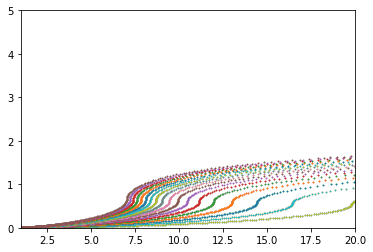

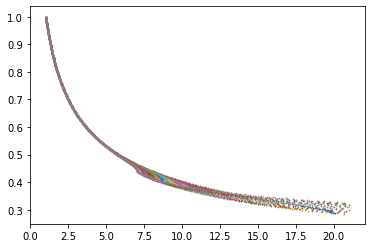

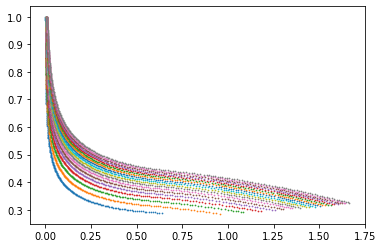

In [139]:
import Adiabatic_wind_solver as aws
s=aws.solver(1.1,.1)
s.makePlots(.001,.01,.0005,True,20,5);

v vs r:
T vs r:
T vs v:


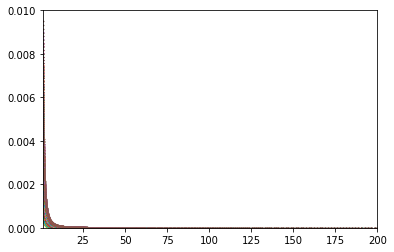

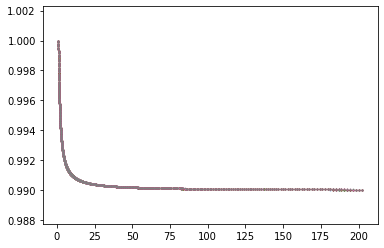

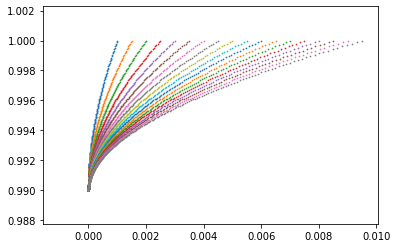

In [140]:
s.makePlots(.001,.01,.0005,False,200,.01);

Lower bound on v0:  0.005075313377380374
Upper bound on v0:  0.005075325393676755
Estimated v0:  0.005075319385528564
Estimated error:  6.008148190333323e-09


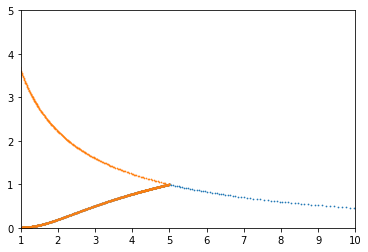

In [137]:
v0avg=s.findV0(.004,.006,.0001)

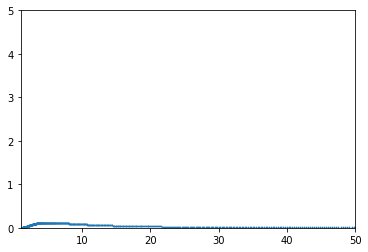

In [136]:
s.makePlot(.001,AV=False,xrange=50);

True
True
0.7145761164770619


0

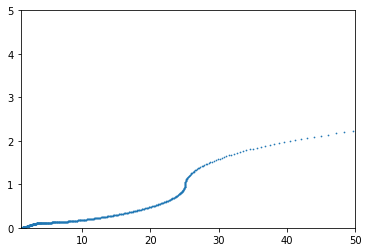

In [134]:
print(type(np.array([dx,du]))==np.ndarray)
print(np.shape([1,[2,3,4]])==(2,))
gamma=1
print(s.generateFunc(np.array([1,.001,0]))[2][-1])
s.makePlot(.001,xrange=50)